In [2]:
base_path='/content/drive/MyDrive/dataset'
train_path='/content/drive/MyDrive/dataset'
val_path='/content/drive/MyDrive/dataset'
test_path='/content/drive/MyDrive/dataset'

In [27]:
from keras.layers import Input, Flatten
from skimage.io import imshow,imread
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import image_dataset_from_directory
import os
import glob

In [28]:
batch_size = 32
target_size=(224, 224)
class_mode='categorical'

In [29]:
def generate_dataset(path):
    print("\nTotal for trainning : ", end=" ")
    ds = image_dataset_from_directory(path ,
                                      image_size=target_size,
                                          batch_size=batch_size)
    class_names = ds.class_names
    print(class_names)
    num_classes=len(ds.class_names)


    image_data_generator = ImageDataGenerator(rescale = 1./255,
                                      fill_mode = 'nearest',
                                      samplewise_std_normalization=True,
                                      samplewise_center=True,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      )
    test_image_data_generator = ImageDataGenerator(rescale = 1./255)

    print("\nFor Training : ", end=" ")
    train_generator = image_data_generator.flow_from_directory(train_path,
                                                      target_size=target_size,
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      interpolation="nearest",
                                                      color_mode='rgb')


    print("\nFor Val : ", end=" ")
    validation_generator = image_data_generator.flow_from_directory(val_path,
                                                           target_size=target_size,
                                                           batch_size=batch_size,
                                                           class_mode='categorical',
                                                           shuffle = False,
                                                           interpolation="nearest",
                                                           color_mode='rgb')
    print("\nFor Test : ", end=" ")
    test_generator = test_image_data_generator.flow_from_directory(test_path,
                                                           target_size=target_size,
                                                           batch_size=batch_size,
                                                           class_mode='categorical',
                                                           shuffle=False,
                                                           interpolation="nearest",
                                                           color_mode='rgb')
    plt.figure(figsize=(30, 30))
    for images, labels in ds.take(1):
        for i in range(num_classes):
            ax = plt.subplot(9, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    return train_generator,validation_generator,test_generator,train_generator.image_shape,class_names,num_classes

In [30]:
def initiate_model_VGG16(no_of_classes, image_size,fine_tune=0,dropout=0.0):
    vgg=VGG16(include_top=False,
        weights='imagenet',
        input_shape=image_size,
        classes=no_of_classes
    )

    if fine_tune > 0:
        for layer in vgg.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in vgg.layers:
            layer.trainable = False

    top_model = Flatten(name="flatten")(vgg.output)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    if dropout > 0 :
        top_model = Dropout(dropout)(top_model)
        output_layer  = Dense(no_of_classes, activation='softmax')(top_model)

    model = Model(inputs=vgg.input, outputs= output_layer,name="VGG16")
    return model

In [31]:
def modelSummary(model):
    model.summary()

In [32]:
def initiateParams_modelComplie(model, learning_rate):
    optimizer=AdamW(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.Recall()]
                )
    rlr = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=4,
                               verbose=1,
                               mode='auto',
                               min_lr=1e-5,
                               min_delta=0.001)

    checkpoint = ModelCheckpoint('VGG16.h5',
                               verbose=1,
                               save_best_only=True)

    return model,rlr, checkpoint

In [33]:
def modelFit(model, rlr, checkpoint, epochs=15, batchSize = 32):

    model_fit = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[rlr, checkpoint]
    )

    return model_fit


Total for trainning :  Found 600 files belonging to 2 classes.
['begnin', 'malignant']

For Training :  Found 600 images belonging to 2 classes.

For Val :  Found 600 images belonging to 2 classes.

For Test :  Found 600 images belonging to 2 classes.


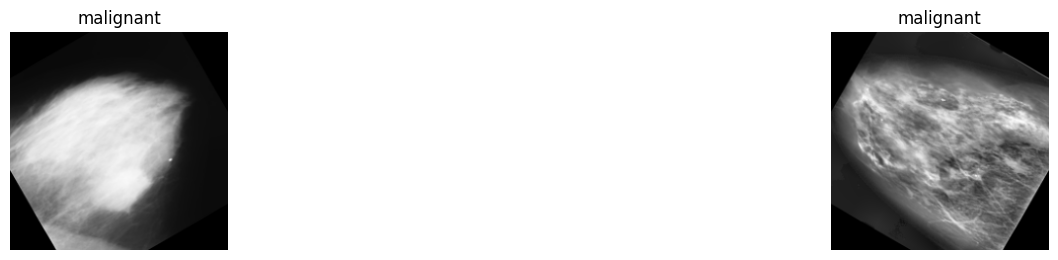

In [34]:
train_ds,val_ds,test_ds,image_batch,class_names,num_classes=generate_dataset(base_path)

In [35]:
def evalModel(model,dataset=test_ds):
    evl = model.evaluate(dataset)
    acc = evl[1]*100
    msg=f'recall on the Test Set = {acc:5.2f} %'
    print(msg)
    return acc


In [36]:
def saveModel(model):
    model.save("/content/drive/MyDrive/VGG16.h5")
    print("Model Saved!")

In [37]:
def plotOutput(hist_vgg,str=''):
    acc_vgg = hist_vgg.history['recall'+str]
    val_acc_vgg = hist_vgg.history['val_recall'+str]

    loss_vgg = hist_vgg.history['loss']
    val_loss_vgg =hist_vgg.history['val_loss']

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(acc_vgg, label='Training recall')
    plt.plot(val_acc_vgg, label='Validation recall')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('recall')


    plt.title('Training and Validation recall ')

    plt.subplot(3, 2, 2)
    plt.plot( loss_vgg, label='Training Loss')
    plt.plot( val_loss_vgg, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('Training and Validation Loss')

    plt.show()
    plt.savefig('_graph.png')



In [38]:
def plot_confusion_matrix(model,classes,dataset=test_ds):

    y_true = dataset.classes
    y_pred = model.predict(dataset)
    y_pred = np.argmax(y_pred, axis=1)
    conf_mat = confusion_matrix(y_true, y_pred)
    accuracy = np.trace(conf_mat) / float(np.sum(conf_mat))
    misclass = 1 - accuracy
    ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()


In [15]:
model=initiate_model_VGG16(num_classes,
                                 image_batch,fine_tune=2,dropout=0.2)


58889256/58889256 [==============================] - 0s 0us/step


In [16]:
modelSummary(model)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
model_vgg, rlr, checkpoint=initiateParams_modelComplie(model=model,
                                                       learning_rate=0.001)

In [20]:
model_fit = modelFit(model_vgg,
                    rlr,
                  checkpoint,
                   epochs=15,
                   batchSize = 32)

Epoch 1/15
19/19 [==============================] - ETA: 0s - loss: 4.2119 - recall: 0.5083 
Epoch 1: val_loss improved from inf to 0.58717, saving model to VGG16.h5
19/19 [==============================] - 567s 30s/step - loss: 4.2119 - recall: 0.5083 - val_loss: 0.5872 - val_recall: 0.7400 - lr: 0.0010
Epoch 2/15
19/19 [==============================] - ETA: 0s - loss: 0.3005 - recall: 0.8600 
Epoch 2: val_loss improved from 0.58717 to 0.12887, saving model to VGG16.h5
19/19 [==============================] - 585s 32s/step - loss: 0.3005 - recall: 0.8600 - val_loss: 0.1289 - val_recall: 0.9567 - lr: 0.0010
Epoch 3/15
19/19 [==============================] - ETA: 0s - loss: 0.0493 - recall: 0.9817 
Epoch 3: val_loss improved from 0.12887 to 0.01742, saving model to VGG16.h5
19/19 [==============================] - 547s 30s/step - loss: 0.0493 - recall: 0.9817 - val_loss: 0.0174 - val_recall: 0.9900 - lr: 0.0010
Epoch 4/15
19/19 [==============================] - ETA: 0s - loss: 0.0220

In [39]:
saveModel(model_vgg)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved!


In [40]:
accuracy=evalModel(model_vgg)

19/19 [==============================] - 254s 13s/step - loss: 0.7130 - recall: 0.8183
recall on the Test Set = 81.83 %


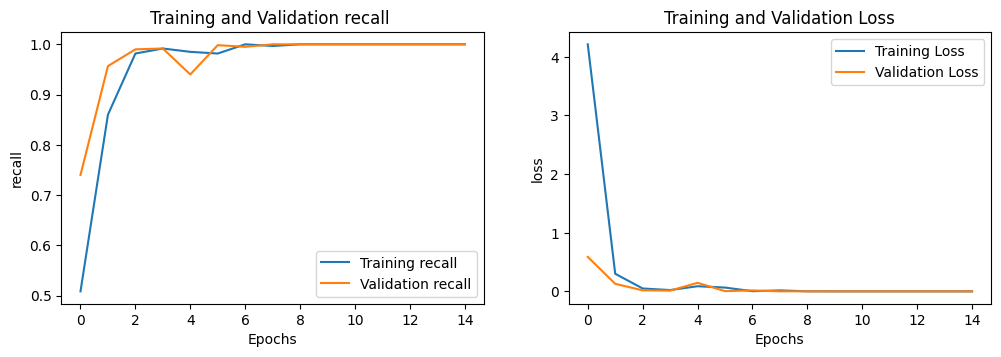

<Figure size 640x480 with 0 Axes>

In [22]:
plotOutput(hist_vgg=model_fit,str='')

19/19 [==============================] - 262s 14s/step


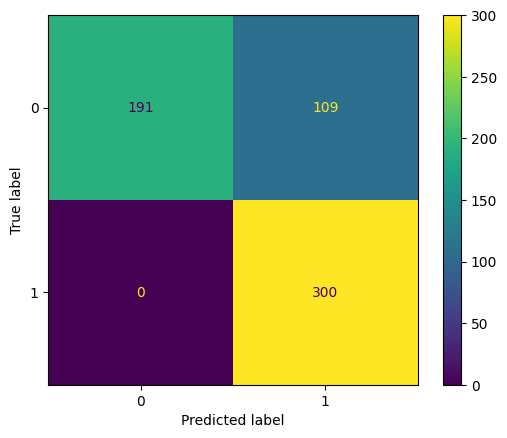

In [23]:
plot_confusion_matrix(model_vgg, classes=class_names)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
